# Стартапы

## 0.Описание проекта

### 0.1.Задача проекта

Разработать модель для предсказания успешности стартапа (закроется или нет)

### 0.2.Описание данных

Датасет состоит из двух файлов: тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'

- kaggle_startups_train_01.csv - информация (53 000) стартапах, которые будут использоваться в качестве обучающих данных.
- kaggle_startups_test_01.csv - информация (13 000) стартапах, которые будут использоваться в качестве тестовых данных. Наша задача - предсказать значение 'status' для каждого стартапа из этого датасета.
 - kaggle_startups_sample_submit_01.csv - файл с примером предсказаний в правильном формате.
name - идентификатор (название) стартапа в тестовом наборе.
status - целевой признак. Для каждого стартапа необходимо предсказать категориальное значение соответствующее прогнозу ['operating', 'closed'].

### 0.3.Описание полей данных

- name - Название стартапа
- category_list - Список категорий, к которым относится стартап
- funding_total_usd - Общая сумма финансирования в USD
- status - Статус стартапа (закрыт или действующий)
- country_code - Код страны
- state_code - Код штата
- region - Регион
- city - Город
- funding_rounds - Количество раундов финансирования
- founded_at - Дата основания
- first_funding_at - Дата первого раунда финансирования
- last_funding_at - Дата последнего раунда финансирования
- closed_at - Дата закрытия стартапа (если применимо)
- lifetime - Время существования стартапа в днях

### 0.4.План выполения проекта

- загрузка и ознакомление с данными,
- предварительная обработка,
- полноценный разведочный анализ,
- разработка новых синтетических признаков,
- проверка на мультиколлинеарность,
- отбор финального набора обучающих признаков,
- выбор и обучение моделей,
- итоговая оценка качества предсказания лучшей модели,
- анализ важности ее признаков,
- подготовка отчета по исследованию.

## 1. Загрузка и подготовка данных

### 1.1. Чтение данных

In [1]:
# Установим необходимые библиотеки
!pip install phik
!pip install lightgbm
!pip install unidecode
!pip install xgboost
!pip install shap
!pip install category_encoders

In [2]:
# Импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns

from datetime import datetime

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from category_encoders import CatBoostEncoder

from matplotlib.dates import DateFormatter, MonthLocator

from scipy import stats as st

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import root_mean_squared_error, make_scorer, f1_score, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, TargetEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from unidecode import unidecode

import phik
import shap
import os

pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [4]:
sample = pd.read_csv('kaggle_startups_sample_submit_28062024.csv')
test = pd.read_csv('kaggle_startups_test_28062024.csv', parse_dates=['first_funding_at', 'last_funding_at'])
train = pd.read_csv('kaggle_startups_train_28062024.csv', parse_dates=['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'])
city = pd.read_csv('worldcitiespop.csv', low_memory=False)

In [5]:
test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.00,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.00,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.00,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.00,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


In [6]:
# Проверим размеры получившихся датасетов
print(sample.shape)
print(test.shape)
print(train.shape)
print(city.shape)

(13125, 2)
(13125, 11)
(52516, 13)
(3173958, 7)


### 1.2. Изучение общей информации о датасетах

In [7]:
# Создадим функцию для просмотра общей информации о датасетах
def overview_data(data):
    dash = '-' * 50

    print(dash)
    print('Основная информация о данных')
    print(dash)
    print(data.info())
    print('\n')

    print(dash)
    print('Первые строки данных')
    print(dash)
    print(data.head())
    print('\n')

    print(dash)
    print('Описательная статистика')
    print(dash)
    print(data.describe())
    print('\n')

    print(dash)
    print('Пропущенные значения')
    print(dash)
    print(data.isna().sum())
    print('\n')

    print(dash)
    print('Дубликаты')
    print(dash)
    print(data.duplicated().sum())
    print('\n')

In [8]:
# Выведем общую информацию о датасете train
overview_data(train)

--------------------------------------------------
Основная информация о данных
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datet

In [9]:
# Выведем общую информацию о датасете train
overview_data(test)

--------------------------------------------------
Основная информация о данных
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(

In [10]:
overview_data(sample)

--------------------------------------------------
Основная информация о данных
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    13125 non-null  object
 1   status  13125 non-null  object
dtypes: object(2)
memory usage: 205.2+ KB
None


--------------------------------------------------
Первые строки данных
--------------------------------------------------
                     name     status
0              Crystalsol     closed
1        JBI Fish & Wings  operating
2                COINPLUS     closed
3  Imagine Communications     closed
4                   DNA13  operating


--------------------------------------------------
Описательная статистика
--------------------------------------------------
              name     status
count        13125      13125
unique       13125          2
top  

In [11]:
overview_data(city)

--------------------------------------------------
Основная информация о данных
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3173958 entries, 0 to 3173957
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Country     object 
 1   City        object 
 2   AccentCity  object 
 3   Region      object 
 4   Population  float64
 5   Latitude    float64
 6   Longitude   float64
dtypes: float64(3), object(4)
memory usage: 169.5+ MB
None


--------------------------------------------------
Первые строки данных
--------------------------------------------------
  Country        City  AccentCity Region  Population  Latitude  Longitude
0      ad       aixas       Aixàs     06         NaN     42.48       1.47
1      ad  aixirivali  Aixirivali     06         NaN     42.47       1.50
2      ad  aixirivall  Aixirivall     06         NaN     42.47       1.50
3      ad   aixirvall   Aixirvall     06         NaN

### Вывод

Датасет train
- в колонках funding_rounds, founded_at, first_funding_at, last_funding_at, closed_at, status пропусков нет
- в колонке name один пропуск
- в остальных колонках от 2465 до 47599 пропусков
- пропуски в колоне closed_at скорее всего вызваны тем что стартап все еще существует или тем, что он существовал на момент акутализации данных
- пропуски в колонке funding_total_usd скорее всего вызваны тем что финансирования не было
- в колонках с датами не верный формат данных object
- в колонке funding_total_usd можно изменить формат на int т.к. думаю что центы в сумме финансирования не влияют на сумму
- явных дубликатов нет

Датасет test
- в колонках funding_rounds, first_funding_at, last_funding_at, status, name пропусков нет
- в остальных колонках от 591 до 2578 пропусков
- есть колонка lifetime - срок жизни стартапа, эту колонку нужно будет добавить в датасет train
- нет колонок founded_at и closed_at они заменены колонкой lifetime
- явных дубликатов нет

## 2. Анализ признаков

### 2.1. Анализ числовых признаков

In [12]:
# Функция построения диаграмм для числовых признаков
def num_diag(data, x, xlabel, ylabel, hue=None):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.histplot(
        data=data,
        x=x,
        hue=hue,
        ax=axes[0],
        stat="density",
        bins=20,
        common_norm=False
    )
    axes[0].set_title(f'Гистограмма по {xlabel}')
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel(ylabel)

    sns.boxplot(
        data=data,
        x=x,
        ax=axes[1]
    )
    axes[1].set_title(f'Диаграмма размаха {xlabel}')
    axes[1].set_xlabel(xlabel)
    axes[1].set_ylabel(ylabel)

    plt.tight_layout()
    plt.show()

In [13]:
# Функция построения диаграмм для категориальных признаков
def cat_diag(data, x, xlabel, hue=None, threshold=0.015):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    value_counts = data[x].value_counts(normalize=True)
    small_categories = value_counts[value_counts < threshold].index
    data_modified = data.copy()
    data_modified[x] = data_modified[x].apply(lambda val: 'Другие' if val in small_categories else val)

    sns.countplot(
        data=data_modified,
        x=x,
        hue=hue,
        ax=axes[0],
        order=data_modified[x].value_counts().index
    )
    axes[0].set_title(f'Диаграмма по {xlabel}')
    axes[0].set_ylabel('Количество')
    axes[0].set_xlabel(xlabel)
    axes[0].tick_params(axis='x', rotation=45)

    pie_data = data_modified[x].value_counts(normalize=True)

    pie_data.plot(
        kind='pie',
        labels=pie_data.index,
        legend=False,
        autopct='%1.0f%%',
        ax=axes[1],
        startangle=90,
        counterclock=False
    )
    axes[1].set_title(f'Распределение долей {xlabel}')
    axes[1].set_ylabel('')

    plt.tight_layout()
    plt.show()

In [14]:
# Создадим функцию для автоматической визуализации признаков в зависимости от типа колонки
def all_diag(df, column_type='numeric', hue=None):
    if column_type == 'numeric':
        columns = df.select_dtypes(include='number').columns
    elif column_type == 'categorical':
        columns = df.select_dtypes(include='object').columns

    for col in columns:
        if column_type == 'numeric':
            print(f"Визуализация численного признака: {col}")
            num_diag(df, x=col, xlabel=col, ylabel='Плотность распределения', hue=hue)
        elif column_type == 'categorical':
            print(f"Визуализация категориального признака: {col}")
            cat_diag(df, x=col, xlabel=col, hue=hue)

Визуализация численного признака: funding_total_usd


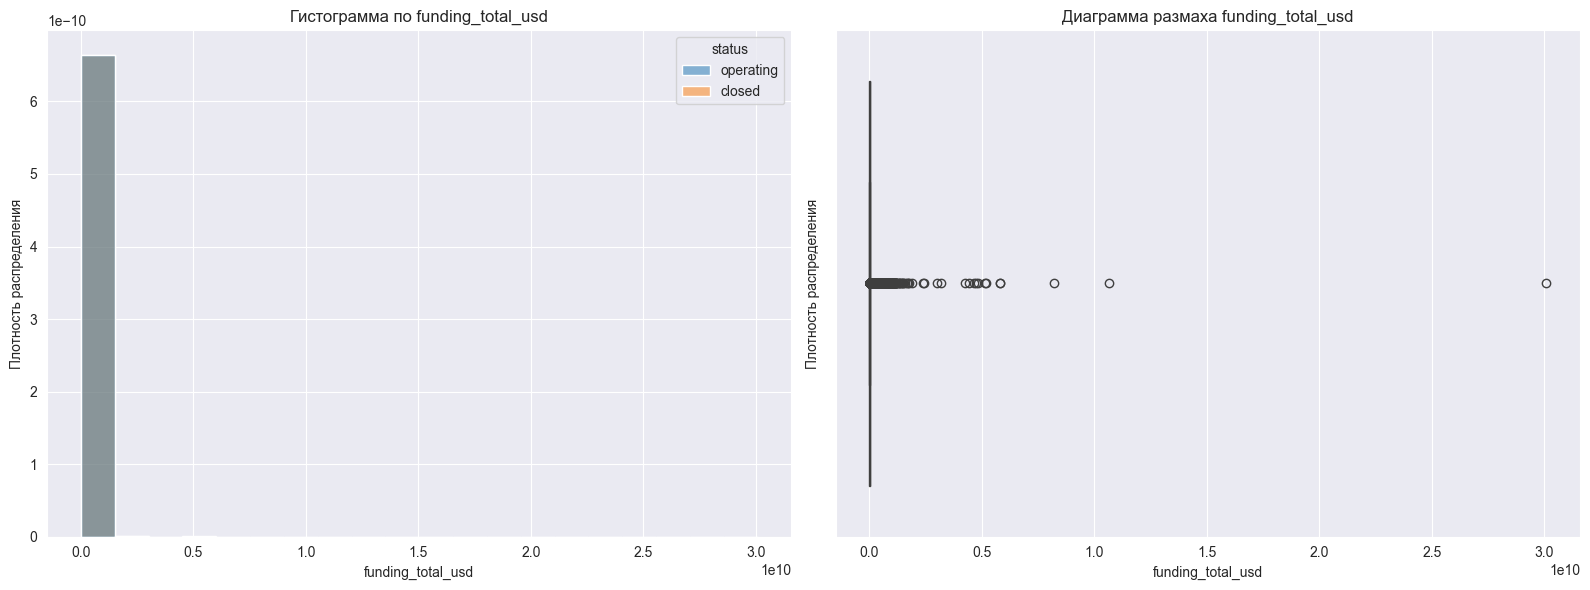

Визуализация численного признака: funding_rounds


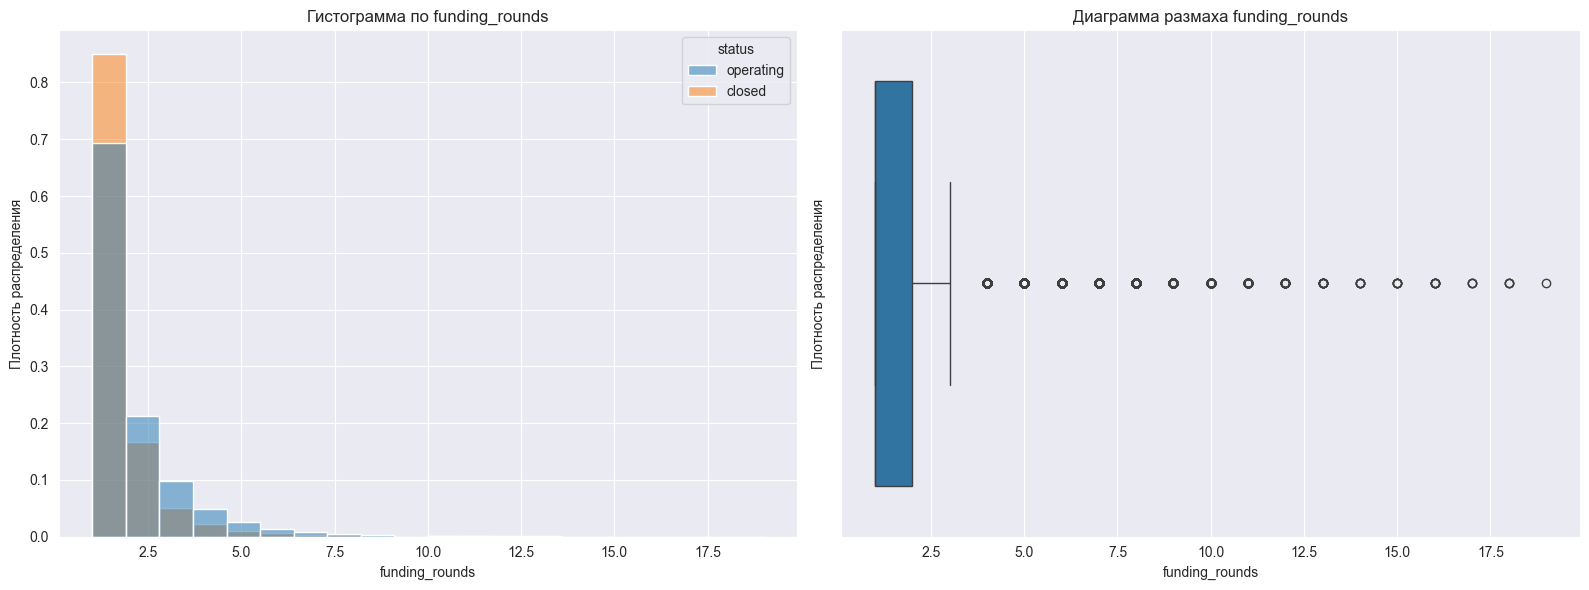

In [15]:
all_diag(train, column_type='numeric', hue='status')

In [16]:
train['funding_total_usd'].describe()

count         42447.00
mean       18247480.66
std       187117301.32
min               1.00
25%          336027.50
50%         2000000.00
75%        10000000.00
max     30079503000.00
Name: funding_total_usd, dtype: float64

In [17]:
(train['funding_rounds'] > 7).sum()

447

funding_total_usd
- среднее значение финансирования составляет 18.2 млн.
- максимальное финансирование около 3 млрд. - думаю это реальное значение, было одно такое финасирование
- есть значение финансирования в 1 доллар
- большинство значений суммы финансирования находится в диапазоне между 336 тыс. и 10 млн

In [18]:
train['funding_rounds'].describe()

count   52516.00
mean        1.74
std         1.37
min         1.00
25%         1.00
50%         1.00
75%         2.00
max        19.00
Name: funding_rounds, dtype: float64

funding_total_usd
- среднее значение раундов финансирования составляет 1.74 раунда
- максимальное количество раундов 19
- минимальное количество раундов 1
- большинство значений раундов финансирования 1-2 раунда, все что больше единичные значения
- закрытых проектов после 5-6 раундов финансирования практически нет, однако и проектов с таким количеством финанирования тоже практически нет.

In [19]:
# Удалим столбцы с funding_rounds <= 7
train = train[train['funding_rounds'] <= 7]

In [20]:
train.shape

(52069, 13)

### 2.2. Анализ категориальных признаков

Подготовим данные к анализу

In [21]:
# Приведем все даты к нужному типу
date_cols1 = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']
date_cols2 = ['first_funding_at', 'last_funding_at']
train[date_cols1] = train[date_cols1].apply(pd.to_datetime, errors='coerce')
test[date_cols2] = test[date_cols2].apply(pd.to_datetime, errors='coerce')

In [22]:
# Создадим столбцы с корневыми и конечными категориями
train['root_cat'] = train['category_list'].str.split('|').str[0]
train['root_cat'] = train['root_cat'].fillna('other')
test['root_cat'] = test['category_list'].str.split('|').str[0]
test['root_cat'] = test['root_cat'].fillna('other')

In [23]:
train = train.drop(columns='category_list')

Визуализация категориального признака: name


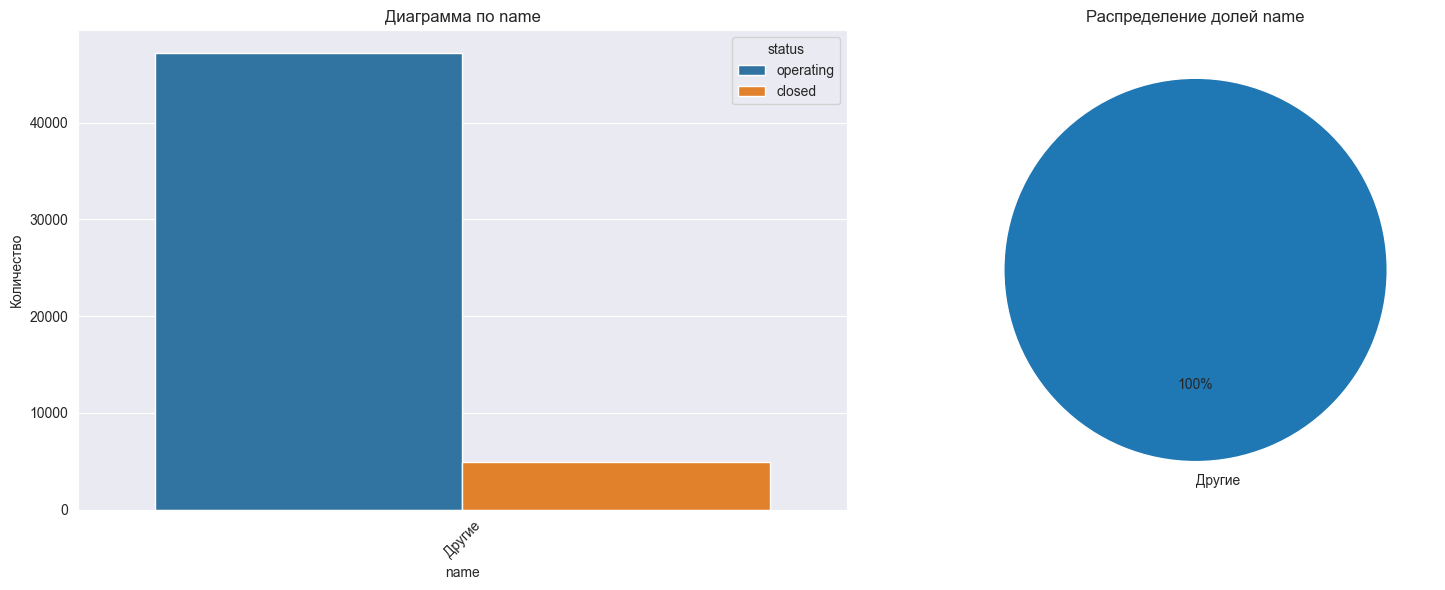

Визуализация категориального признака: status


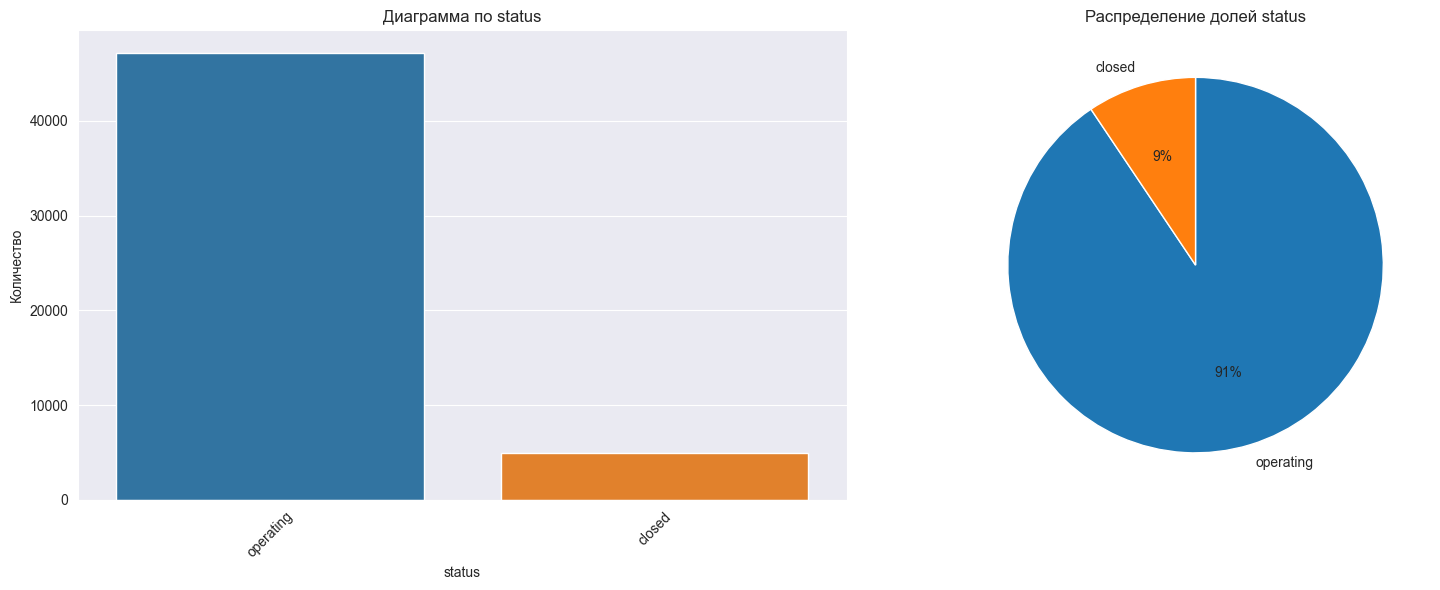

Визуализация категориального признака: country_code


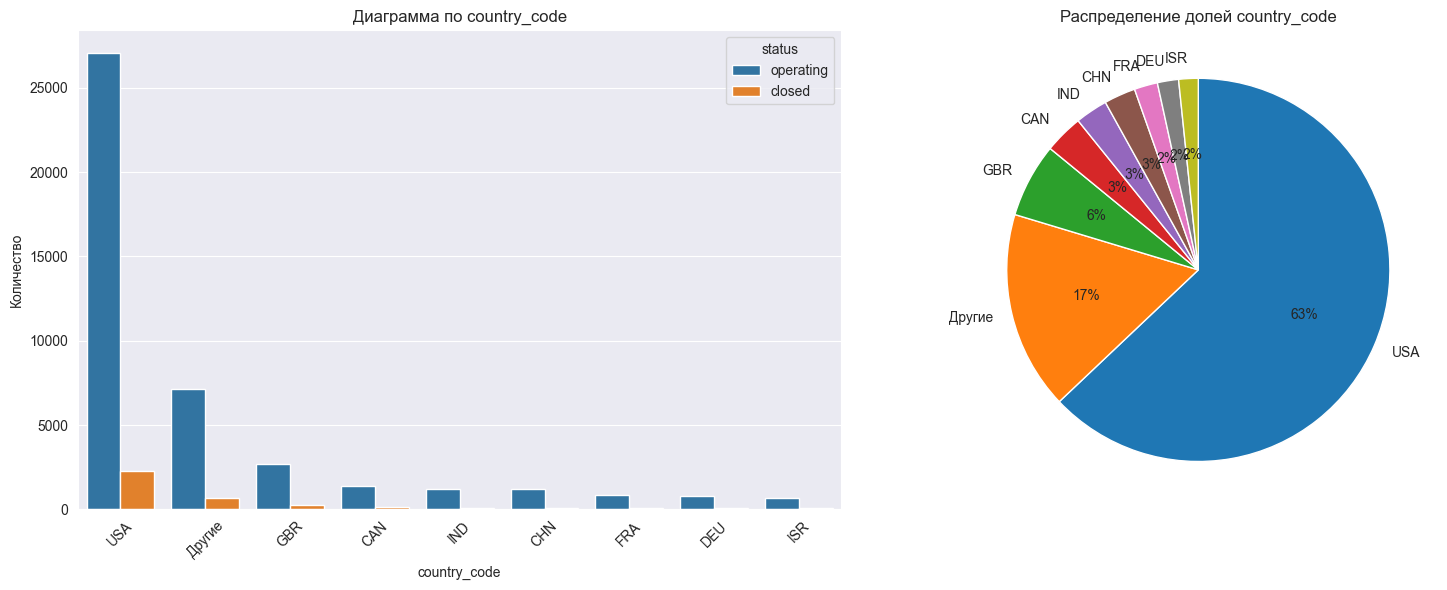

Визуализация категориального признака: state_code


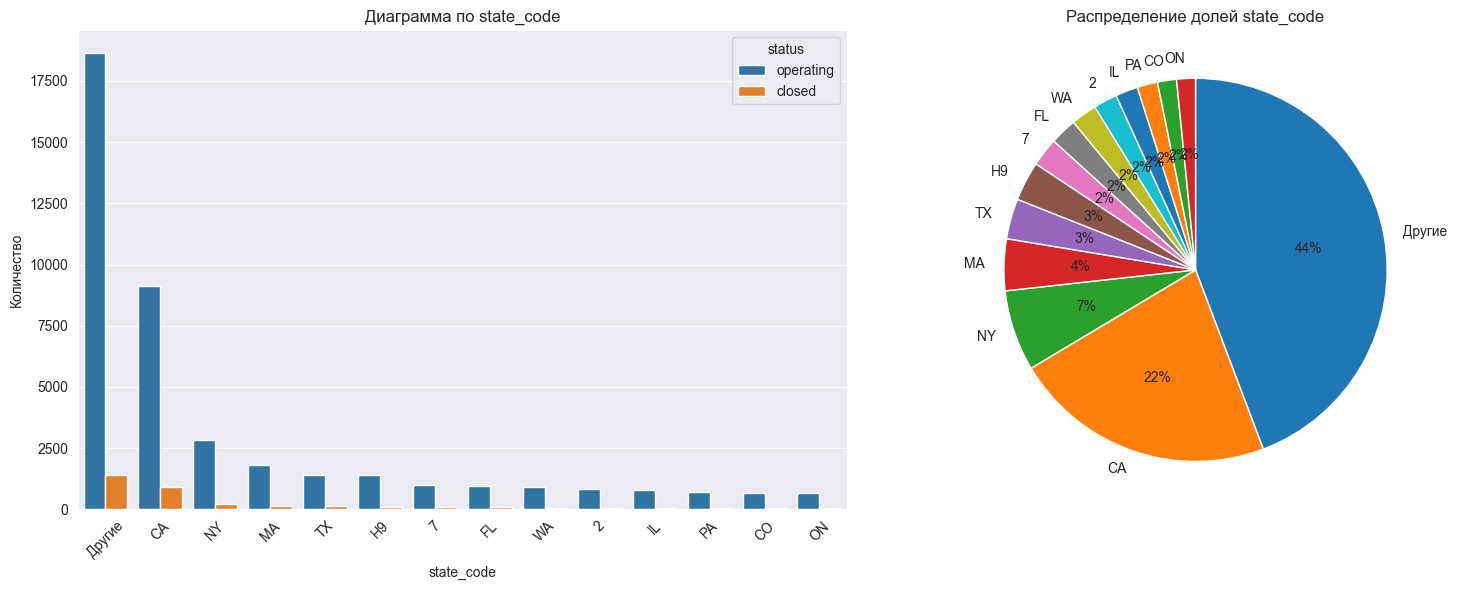

Визуализация категориального признака: region


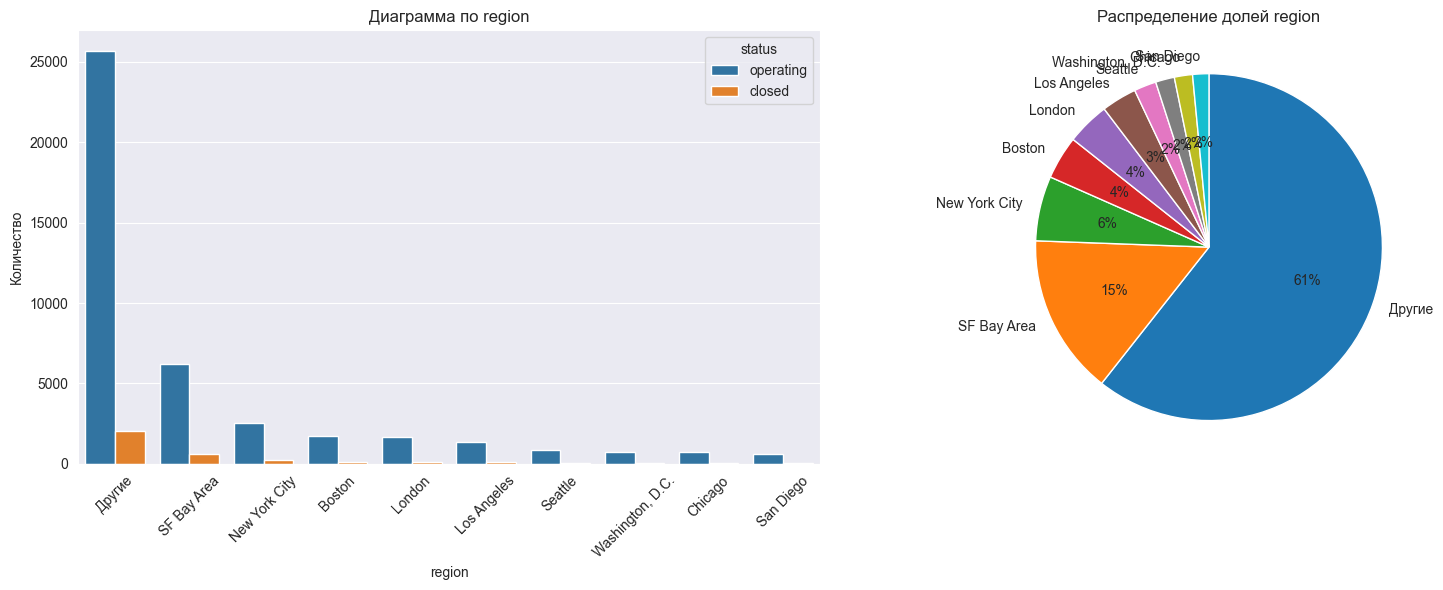

Визуализация категориального признака: city


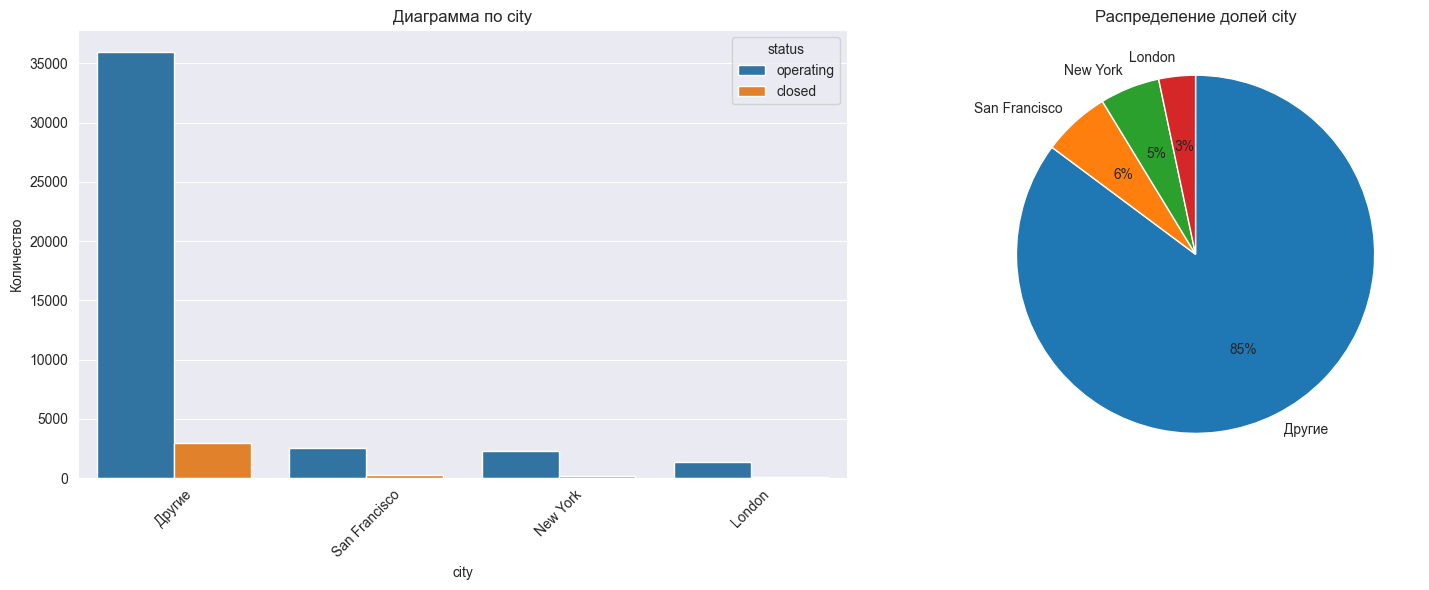

Визуализация категориального признака: root_cat


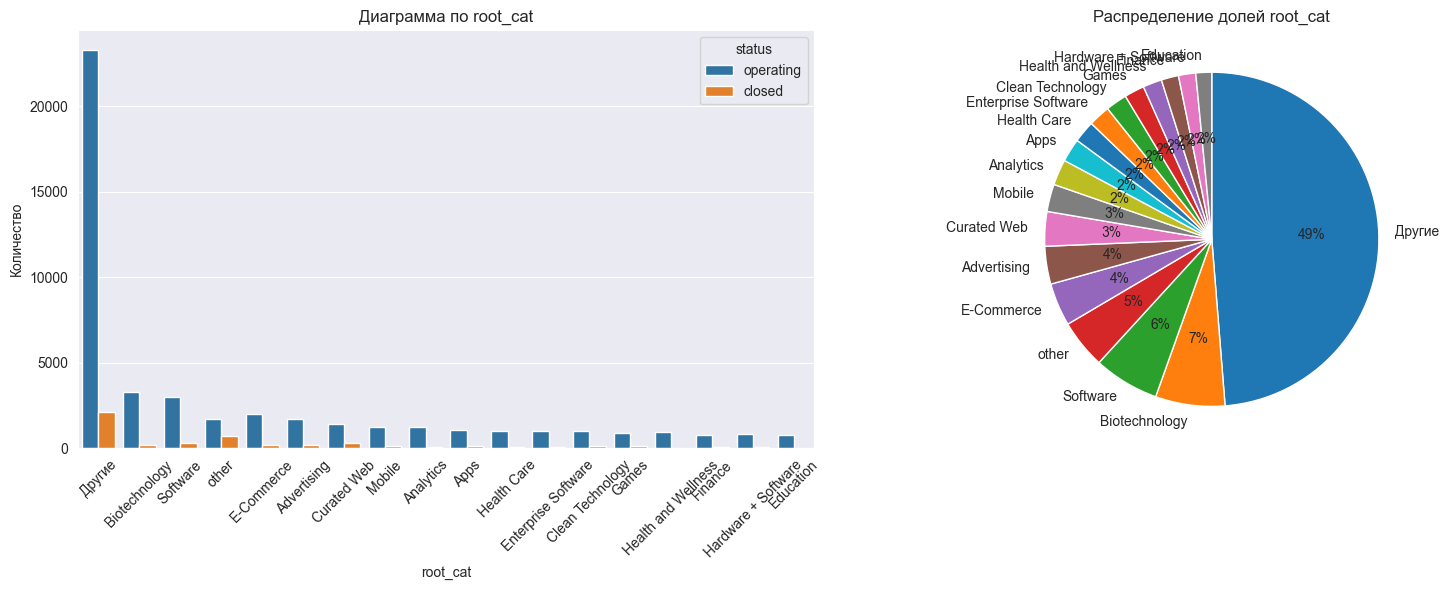

In [24]:
# Визуализируем признаки
all_diag(train, column_type='categorical', hue='status')

При построении графиков значения категориальных признаков занимающие менее 1,5% были собюраны в категорию 'Другие' для лучшей визуализации

- name - все значения уникальны, что ожидаемо
- status - целевой признак, по графику мы видим сильный дисбаланс классов, только 9% из всех стартапов закрылись.
- country_code - основная страна регистрации стартапов - США с долей 63%, затем идут Великобритания и Канада с 6 и 3%.
- state_code - самый распространенный штат регистрации стартапов - Калифорния, за ним идут Нью-Йорк и Массачусетс
- region - самый популярные регион это Область Залива Сан-Франциско и Нью-Йорк с 15% и 6% соответственно
- city - Сан Франциско у нас город стартапов с 63% и Лондон на втором месте всего с 6%
- end-cat - В топе у нас программное обеспечение и биотехнологии
- root-cat - тут также лидирует програмное обеспечение и биотехнологии

- Распределение целевой переменной совпадает с распеределением всех признаков.

In [25]:
# cols_to_check = ['country_code', 'state_code', 'region', 'city', 'root_cat']
# for col in cols_to_check:
#     rare_values = train[col].value_counts()[train[col].value_counts() == 1].index
#     train = train[~train[col].isin(rare_values)]

In [26]:
train.shape

(52069, 13)

In [27]:
#Удалим эти категории


### 2.3. Анализ признаков с датами

In [28]:
# Создадим функцию для визуализации признаков дат
def date_diag(data, date_col, hue=None,
                          figsize=(12, 6)):

    df = data.copy()
    df['year'] = df[date_col].dt.year

    plt.figure(figsize=figsize)
    ax = sns.countplot(
        data=df,
        x='year',
        hue=hue,
        order=sorted(df['year'].unique())
    )

    for container in ax.containers:
        ax.bar_label(container, fmt='%d', padding=3)

    plt.title(f'Распределение данных по годам\n({date_col})')
    plt.xlabel('Год')
    plt.ylabel('Количество записей')
    plt.xticks(rotation=45)

    if hue:
        plt.legend(
            title=hue,
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0
        )

    plt.tight_layout()
    plt.show()

Визуализация категориального признака: first_funding_at


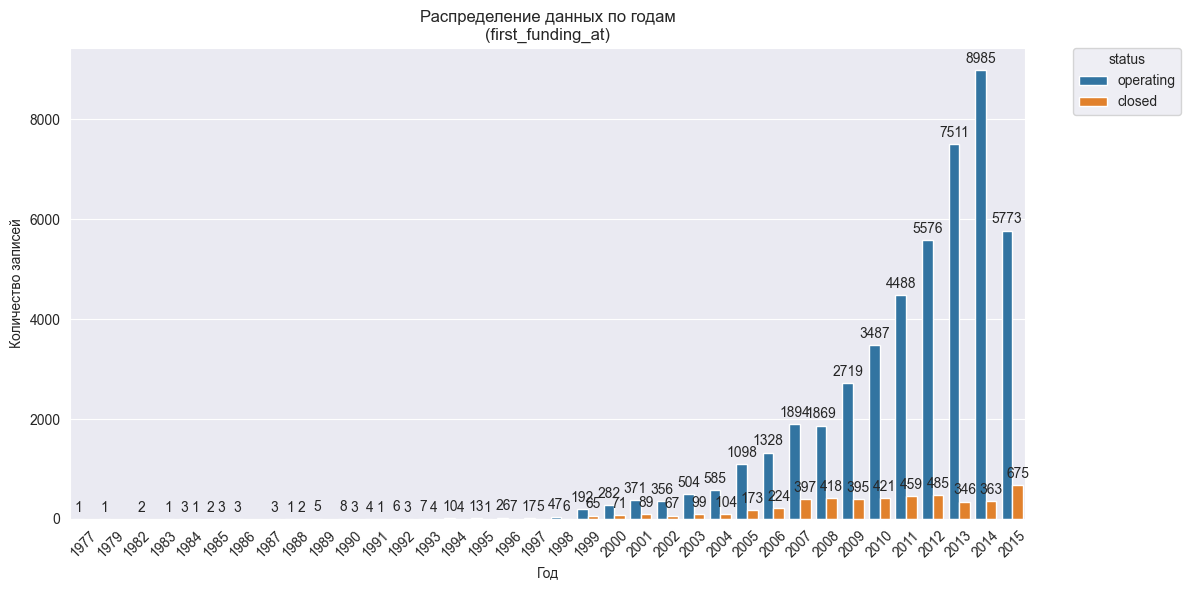

Визуализация категориального признака: last_funding_at


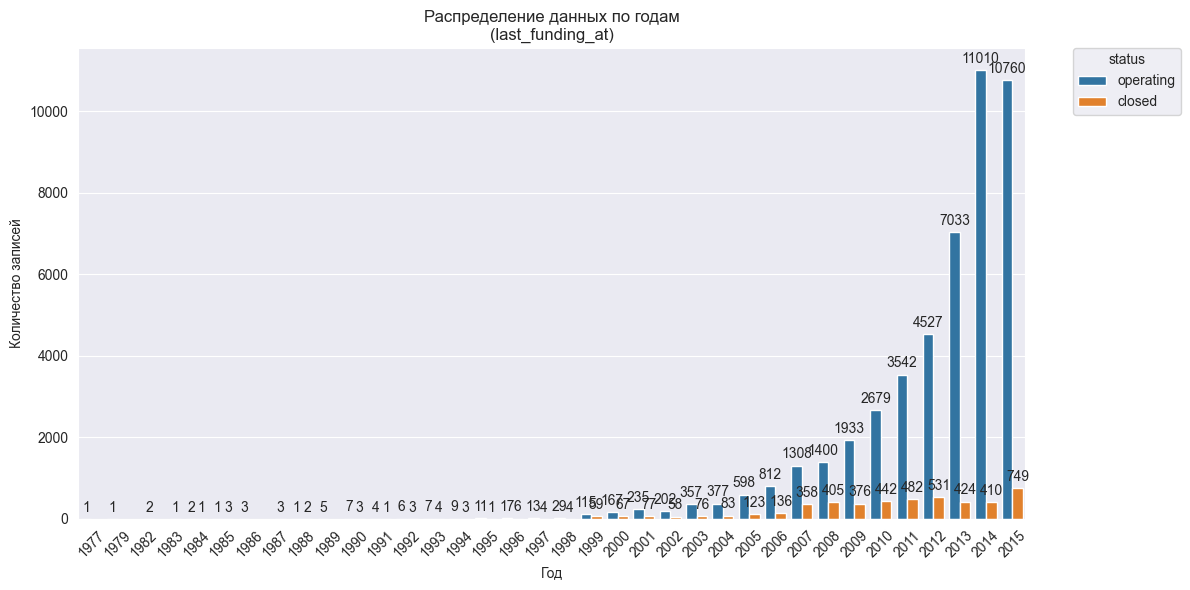

In [29]:
# Визуализируем даты
for date_col in date_cols2:
    print(f"Визуализация категориального признака: {date_col}")
    date_diag(train, date_col, hue='status')

- founded_at - большинство стартапов было основано с 2005 по 2014 год, также в эти периоды приходится основная часть закрытия стартапов. Количество закрытий напрямую с количеством открыти не коррелирует. Максимальное количетво закрытых стартапов было в 2011 году а максимальное количество открытых в 2013.
- first_funding_at - распределение дат первого раунда финансирования совпадают с распределеним с созданием стартапов. Максимальное количество стартапов прошедших первых раундов финансирования было в 2014 году.
- last_funding_at - распределение дат последнего раунда финансирования также похожи на график основания стартапов. Максимальное количество дат посоледнего финансирования было в 2014 и 2015 годах
- closed_at - основное количество закрытия стартапов проходилось с 2008 по 2017 год
- основная активность финансирования, закрытия и открытия стартапов начинается с 90x-2000x годов, до этого активность минамальна



In [30]:
exp_date = pd.to_datetime('2018-01-01')

In [31]:
# Заполним пропуски в столбце closed_at текущей датой
train['closed_at'] = train['closed_at'].fillna(exp_date)

In [32]:
# Создадим стобец lifetime как разницу между датой основания стартапа и разницей закрытия в днях
train['lifetime'] = (train['closed_at'] - train['founded_at']).dt.days

In [33]:
# Создадим еще столбцы разницы между первым и последним финансированием в днях
train['fundingtime'] = (train['last_funding_at'] - train['first_funding_at']).dt.days
test['fundingtime'] = (test['last_funding_at'] - test['first_funding_at']).dt.days

In [34]:
# Создадим еще столбцы разницы между первым и последним финансированием в днях
train['lastf_expd'] = (exp_date- train['last_funding_at']).dt.days
test['lastf_expd'] = (exp_date- test['last_funding_at']).dt.days

In [35]:
# Создадим еще столбцы разницы между первым и последним финансированием в днях
train['firstf_expd'] = (exp_date - train['first_funding_at']).dt.days
test['firstf_expd'] = (exp_date - test['first_funding_at']).dt.days

In [36]:
train.head()

,name,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,root_cat,lifetime,fundingtime,lastf_expd,firstf_expd
0,Lunchgate,828626.00,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2018-01-01,Online Reservations,2998,1310,1127,2437
1,EarLens,42935019.00,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,Manufacturing,4748,1393,1406,2799
2,Reviva Pharmaceuticals,35456381.00,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,Biotechnology,4383,681,1279,1960
3,Sancilio and Company,22250000.00,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01,Health Care,5114,1051,1263,2314
4,WireTough Cylinders,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,2018-01-01,Manufacturing,2791,0,2161,2161


In [37]:
date_cols = ['first_funding_at', 'last_funding_at']

In [38]:
# Добавим в датасеты колонки с годами месяцами и днями по первому и последнему финансированию
for col in date_cols:
    train[f'{col}_year'] = train[col].dt.year
    train[f'{col}_month'] = train[col].dt.month
    train[f'{col}_day'] = train[col].dt.day
    test[f'{col}_year'] = train[col].dt.year
    test[f'{col}_month'] = train[col].dt.month
    test[f'{col}_day'] = train[col].dt.day

In [39]:
# Список столбцов для удаления
columns_to_drop = ['founded_at', 'closed_at']
train = train.drop(columns=columns_to_drop)

In [40]:
train.head()

,name,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,...,lifetime,fundingtime,lastf_expd,firstf_expd,first_funding_at_year,first_funding_at_month,first_funding_at_day,last_funding_at_year,last_funding_at_month,last_funding_at_day
0,Lunchgate,828626.00,operating,CHE,25,Zurich,Zürich,2,2011-05-01,2014-12-01,...,2998,1310,1127,2437,2011,5,1,2014,12,1
1,EarLens,42935019.00,operating,USA,CA,SF Bay Area,Redwood City,4,2010-05-04,2014-02-25,...,4748,1393,1406,2799,2010,5,4,2014,2,25
2,Reviva Pharmaceuticals,35456381.00,operating,USA,CA,SF Bay Area,San Jose,3,2012-08-20,2014-07-02,...,4383,681,1279,1960,2012,8,20,2014,7,2
3,Sancilio and Company,22250000.00,operating,NaN,NaN,NaN,NaN,3,2011-09-01,2014-07-18,...,5114,1051,1263,2314,2011,9,1,2014,7,18
4,WireTough Cylinders,NaN,operating,USA,VA,VA - Other,Bristol,1,2012-02-01,2012-02-01,...,2791,0,2161,2161,2012,2,1,2012,2,1


In [41]:
# Сформируем список новых колонок для анализа
date_num = ['lifetime',
            'first_funding_at_year',
            'first_funding_at_month',
            'first_funding_at_day',
            'last_funding_at_year',
            'last_funding_at_month',
            'last_funding_at_day']

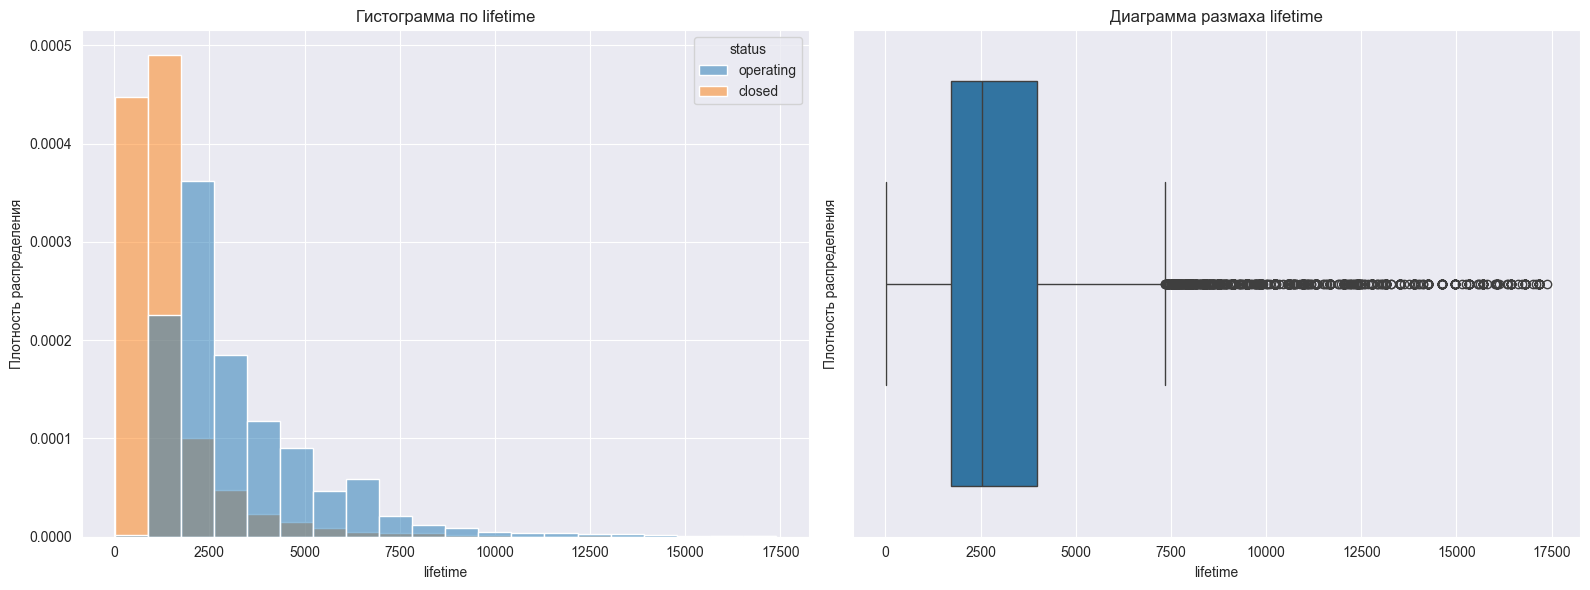

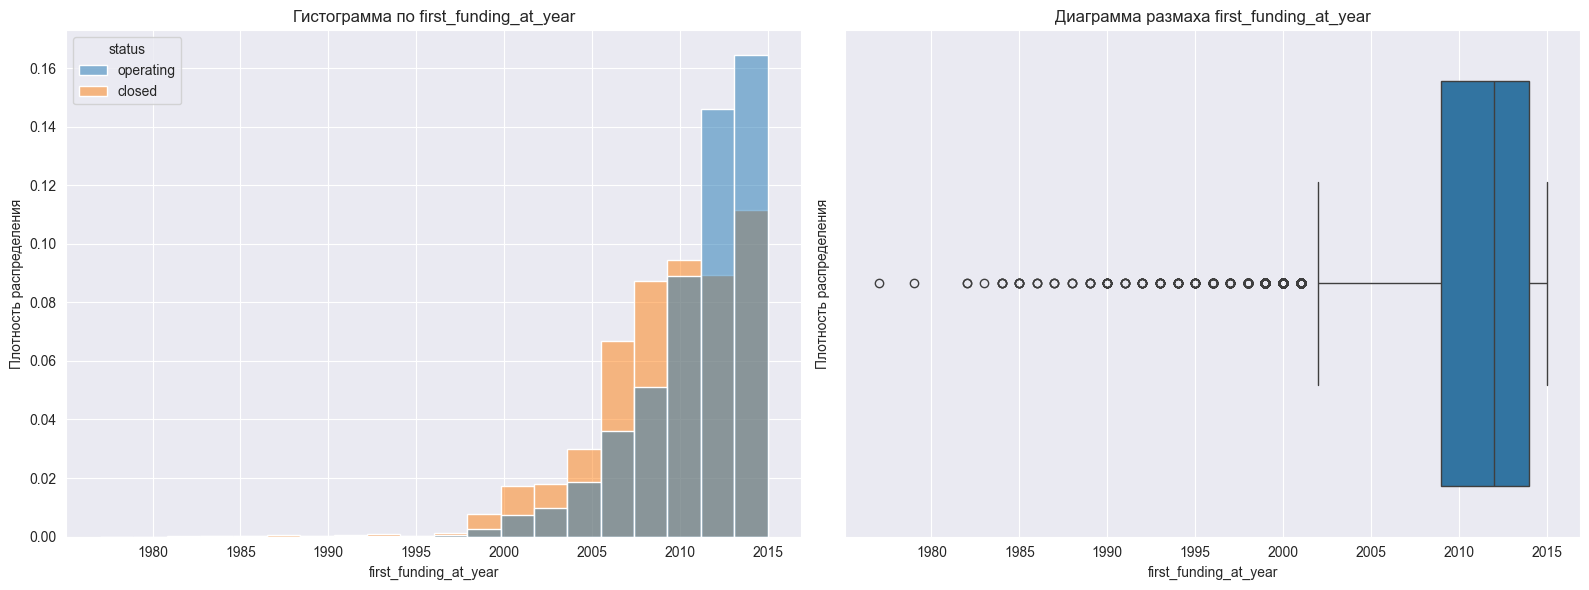

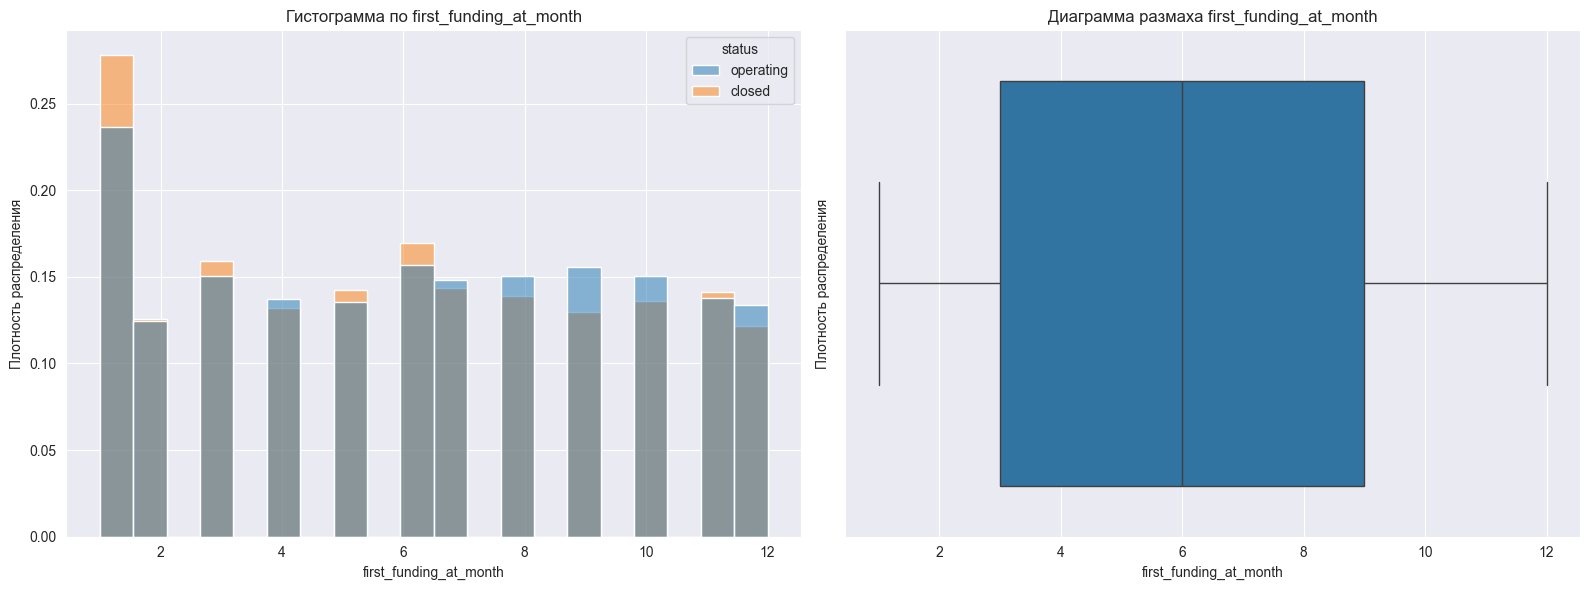

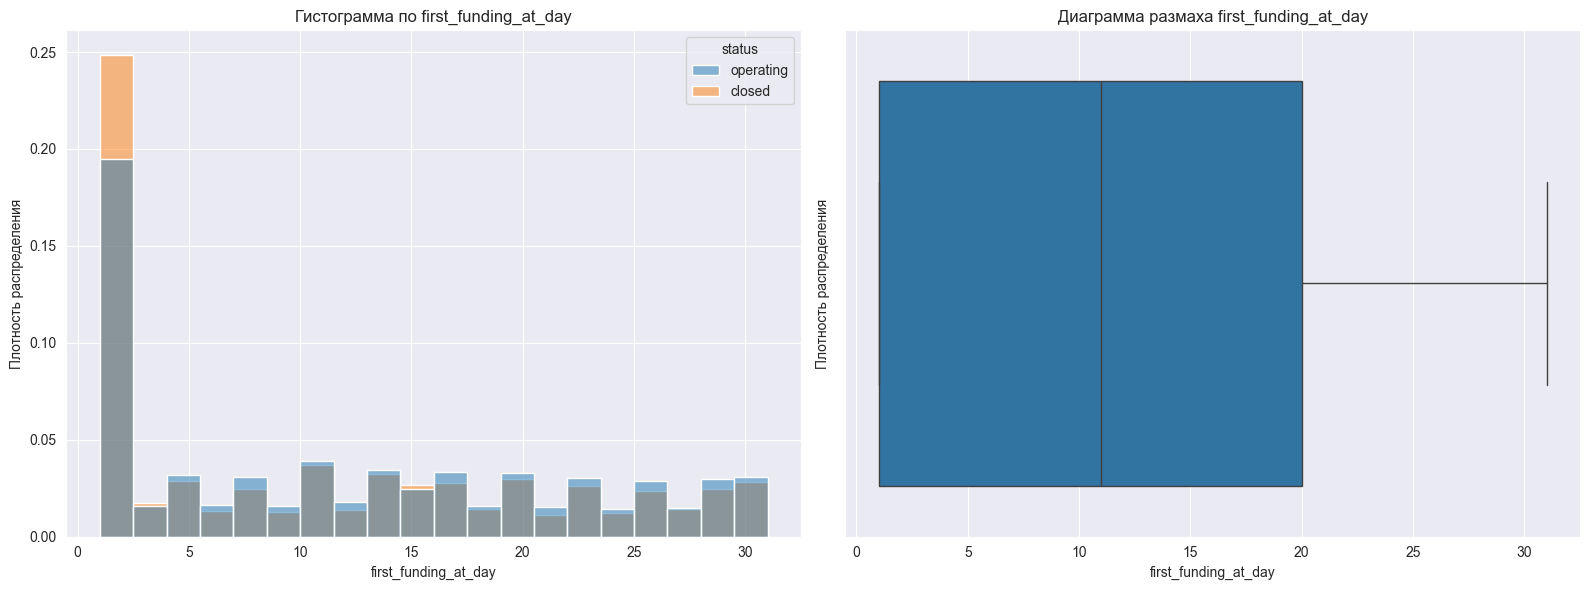

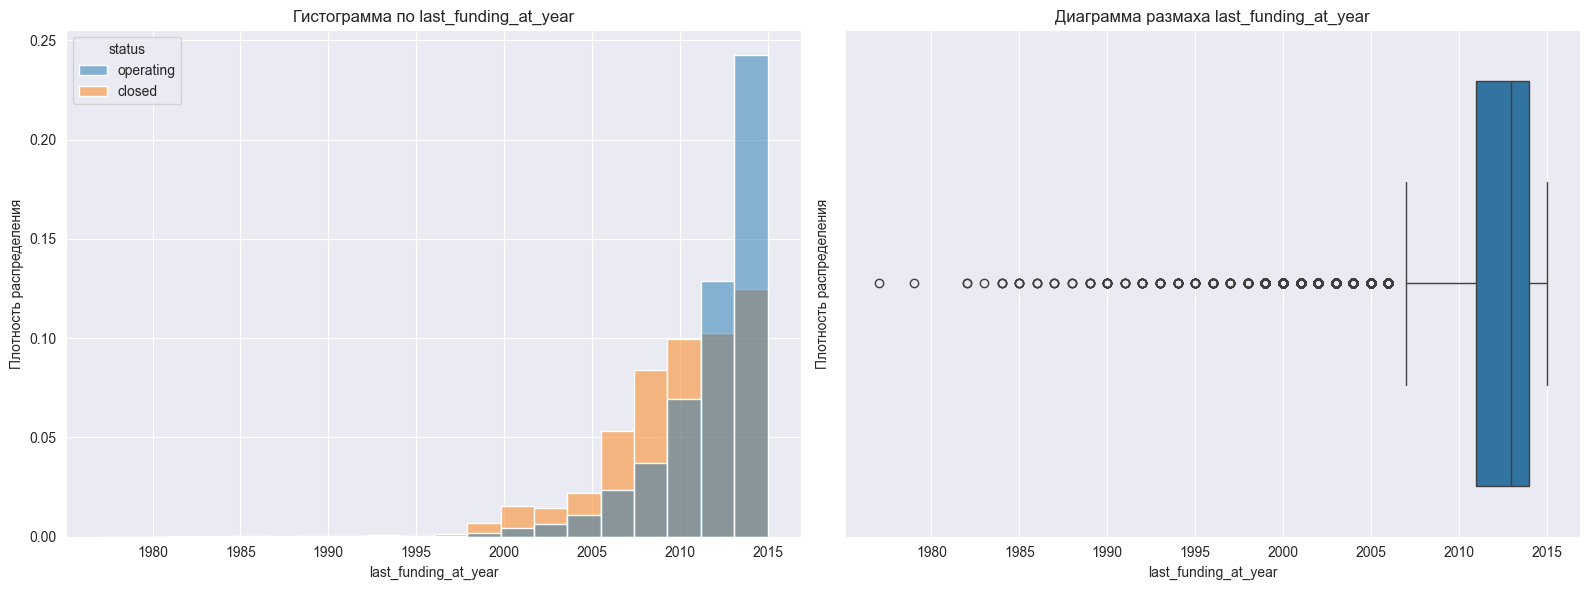

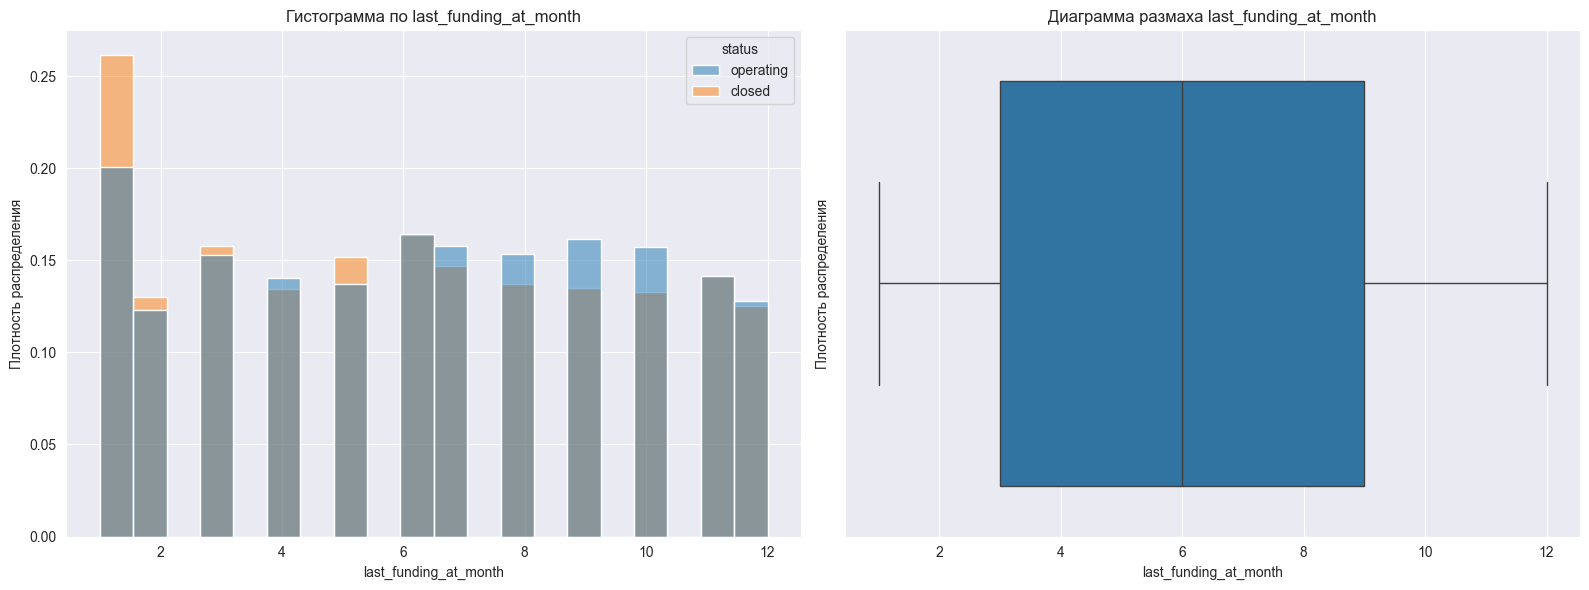

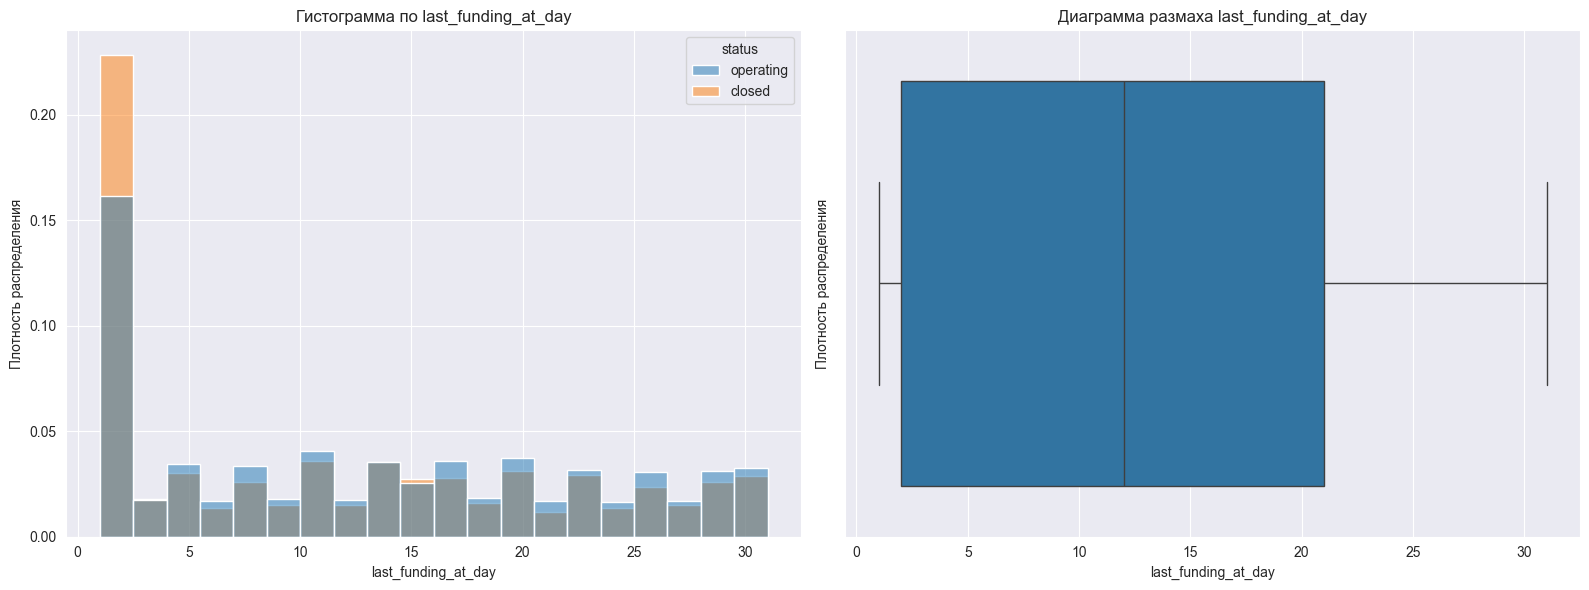

In [42]:
# Построим графики новых колонок
for col in date_num:
    num_diag(train, x=col, xlabel=col, ylabel='Плотность распределения', hue='status')

In [43]:
train['lifetime'].describe()

count   52069.00
mean     3127.32
std      2146.08
min        19.00
25%      1736.00
50%      2533.00
75%      3979.00
max     17378.00
Name: lifetime, dtype: float64

- lifetime - стартапы закрываются в первые 1,5-2 тыс. дней, основная часть работающих стартапов просуществовало уже 4-6 тыс дней.

In [44]:
train['first_funding_at_year'].describe()

count   52069.00
mean     2011.11
std         3.60
min      1977.00
25%      2009.00
50%      2012.00
75%      2014.00
max      2015.00
Name: first_funding_at_year, dtype: float64

- first_funding_at_year - основная масса финансирований стартапов началась в 2005 году и все время росла. Интересно что в более ранние периоды закрывалась большая доля стартапов чем в последующие. Видимо научились правильно выбирать стартапы для финансирования.

In [45]:
train['first_funding_at_month'].describe()

count   52069.00
mean        6.23
std         3.53
min         1.00
25%         3.00
50%         6.00
75%         9.00
max        12.00
Name: first_funding_at_month, dtype: float64

- first_funding_at_month - первое финансирование стартапов чаще всего происходило в середине года.

In [46]:
train['first_funding_at_day'].describe()

count   52069.00
mean       11.96
std         9.88
min         1.00
25%         1.00
50%        11.00
75%        20.00
max        31.00
Name: first_funding_at_day, dtype: float64

- first_funding_at_day - первое финансирование стартапов чаще всего происходило в начале месяца.

In [47]:
train['last_funding_at_year'].describe()

count   52069.00
mean     2012.00
std         3.34
min      1977.00
25%      2011.00
50%      2013.00
75%      2014.00
max      2015.00
Name: last_funding_at_year, dtype: float64

- last_funding_at_year - распределение похоже на первое финансирование, только сдвинуто на год вперед, что логично.

In [48]:
train['last_funding_at_month'].describe()

count   52069.00
mean        6.35
std         3.46
min         1.00
25%         3.00
50%         6.00
75%         9.00
max        12.00
Name: last_funding_at_month, dtype: float64

- last_funding_at_month - последнее финансирование стартапов также чаще всего происходило в середине года.

In [49]:
train['last_funding_at_day'].describe()

count   52069.00
mean       12.74
std         9.78
min         1.00
25%         2.00
50%        12.00
75%        21.00
max        31.00
Name: last_funding_at_day, dtype: float64

- last_funding_at_day - последнее финансирование стартапов чаще всего происходило в начале месяца.

### 2.4. Новые признаки

In [50]:
# Предварительно удалим дубликаты городов с одинаковым названием, оставим только самые крупные
city_filtered = city.sort_values('Population', ascending=False).drop_duplicates(subset=['City'])

Перед присоединением нам нужно заполнить пропуски в столбцах country_code, state_code, region, city. Заполним самым частым значением

In [51]:
# Напишем функцию для заполнения в иерархическом порядке, сначала заполняем самую популярную страну, затем регион и т.д.
# def hierarchical_fillna(df, hierarchy):
#     df_filled = df.copy()
#     for level, col in enumerate(hierarchy):
#         if level == 0:
#             # Заполняем первую колонку общим модом
#             df_filled[col] = df_filled[col].fillna(df_filled[col].mode()[0])
#         else:
#             # Для остальных - модом внутри групп вышестоящих колонок
#             group_cols = hierarchy[:level]
#             fill_values = df_filled.groupby(group_cols)[col].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
#             df_filled[col] = df_filled[col].fillna(fill_values)
#     return df_filled

In [52]:
# Порядок иерархии
# hierarchy = ['country_code', 'state_code', 'region', 'city']

In [53]:
# Применим функцию к обом датасетам
# train = hierarchical_fillna(train, hierarchy)
# test = hierarchical_fillna(test, hierarchy)

In [54]:
# Уберем из названий не английские буквы
train['city'] = train['city'].apply(
    lambda x: unidecode(str(x)) if pd.notna(x) else '')
test['city'] = train['city'].apply(
    lambda x: unidecode(str(x)) if pd.notna(x) else '')

In [55]:
# Приведем все значения к нижнему регистру
train['city'] = train['city'].str.lower()
test['city'] = test['city'].str.lower()

In [56]:
# Объединяем датасет с городами с датасетом train
merged_train = pd.merge(
    train,
    city_filtered,
    left_on=['city'],
    right_on=['City'],
    how='left'
)

In [57]:
# Объединяем датасет с городами с датасетом test
merged_test = pd.merge(
    test,
    city_filtered,
    left_on=['city'],
    right_on=['City'],
    how='left'
)

In [58]:
print(train.shape)
print(test.shape)
print(merged_train.shape)
print(merged_test.shape)


(52069, 21)
(13125, 21)
(52069, 28)
(13125, 28)


In [59]:
# Посмотрим на получившийся датасет
overview_data(merged_train)

--------------------------------------------------
Основная информация о данных
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52069 entries, 0 to 52068
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   name                    52068 non-null  object        
 1   funding_total_usd       42004 non-null  float64       
 2   status                  52069 non-null  object        
 3   country_code            46572 non-null  object        
 4   state_code              45311 non-null  object        
 5   region                  45716 non-null  object        
 6   city                    52069 non-null  object        
 7   funding_rounds          52069 non-null  int64         
 8   first_funding_at        52069 non-null  datetime64[ns]
 9   last_funding_at         52069 non-null  datetime64[ns]
 10  root_cat                52069 non-n

In [60]:
merged_train.head()

,name,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,...,last_funding_at_year,last_funding_at_month,last_funding_at_day,Country,City,AccentCity,Region,Population,Latitude,Longitude
0,Lunchgate,828626.00,operating,CHE,25,Zurich,zurich,2,2011-05-01,2014-12-01,...,2014,12,1,ch,zurich,Zurich,25,346185.00,47.37,8.55
1,EarLens,42935019.00,operating,USA,CA,SF Bay Area,redwood city,4,2010-05-04,2014-02-25,...,2014,2,25,us,redwood city,Redwood City,CA,71969.00,37.49,-122.24
2,Reviva Pharmaceuticals,35456381.00,operating,USA,CA,SF Bay Area,san jose,3,2012-08-20,2014-07-02,...,2014,7,2,us,san jose,San Jose,CA,897460.00,37.34,-121.89
3,Sancilio and Company,22250000.00,operating,NaN,NaN,NaN,,3,2011-09-01,2014-07-18,...,2014,7,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,WireTough Cylinders,NaN,operating,USA,VA,VA - Other,bristol,1,2012-02-01,2012-02-01,...,2012,2,1,gb,bristol,Bristol,B7,430714.00,51.45,-2.58


In [61]:
# Удалим все лишние колонки из обоих датасетов
merged_train = merged_train.drop(columns=['Country', 'City', 'AccentCity', 'Region', 'state_code', 'region', 'city', 'country_code'])
merged_test = merged_test.drop(columns=['Country', 'City', 'AccentCity', 'Region', 'state_code', 'region', 'city', 'country_code'])

### Вывод

## 3. Корреляционный анализ

### 3.1. Матрица корреляций

In [62]:
merged_train.columns

Index(['name', 'funding_total_usd', 'status', 'funding_rounds',
       'first_funding_at', 'last_funding_at', 'root_cat', 'lifetime',
       'fundingtime', 'lastf_expd', 'firstf_expd', 'first_funding_at_year',
       'first_funding_at_month', 'first_funding_at_day',
       'last_funding_at_year', 'last_funding_at_month', 'last_funding_at_day',
       'Population', 'Latitude', 'Longitude'],
      dtype='object')

In [63]:
selected_cols = ['funding_total_usd', 'status', 'funding_rounds',
       'root_cat', 'lifetime',
       'fundingtime', 'first_funding_at_year', 'first_funding_at_month',
       'first_funding_at_day', 'last_funding_at_year', 'last_funding_at_month',
       'last_funding_at_day', 'Population', 'Latitude', 'Longitude', 'lastf_expd', 'firstf_expd']

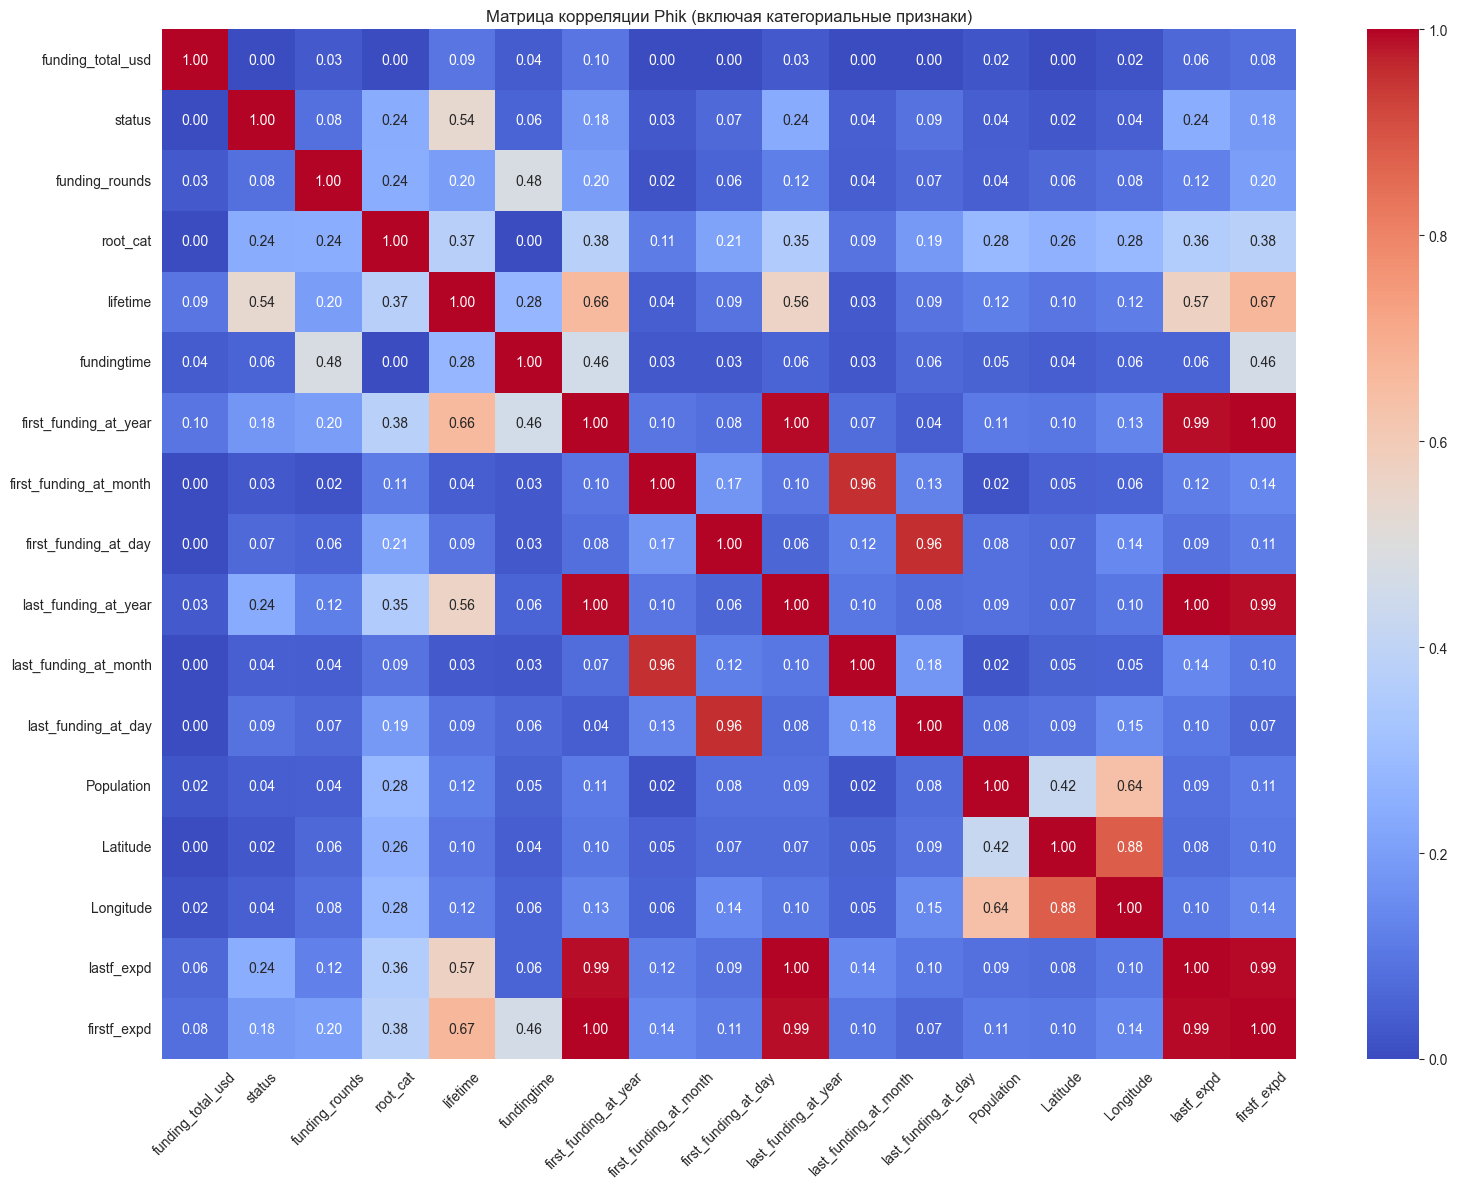

In [64]:
# Вычислим матрицу Phik для всего датафрейма (включая категориальные признаки)
phk = merged_train[selected_cols].phik_matrix(verbose=False)

# Визуализация
plt.figure(figsize=(16, 12))
plt.title('Матрица корреляции Phik (включая категориальные признаки)')
sns.heatmap(phk, annot=True, cmap='coolwarm', fmt=".2f")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [65]:
# train_b = merged_train.select_dtypes(include='number')
# display(train_b.corr('spearman'))

In [66]:
# # Cоздадим матрицу корреaляции phik
# phk = train_b.phik_matrix(verbose=False)

In [67]:
# # Визуализируем матрицу корреляции
# plt.figure(figsize=(12, 8))
# plt.title('Матрица корреляции')
# sns.heatmap(phk, annot=True, cmap='coolwarm', fmt=".2f")
# plt.show()

Сильные положительные корреляции (близкие к 1.0):

last_funding_at_year и first_funding_at_year: Сильная положительная корреляция (1.00) указывает на то, что компании с ранним первым финансированием, как правило, имеют и позднее последнее финансирование. Это логично, поскольку компании, которые привлекают финансирование, как правило, продолжают это делать с течением времени.
Latitude и Longitude: Очень высокая положительная корреляция (0.88) между широтой и долготой, вероятно, указывает на географическую концентрацию данных.
Сильные отрицательные корреляции (близкие к -1.0): В этой матрице нет сильных отрицательных корреляций.

Умеренные корреляции (близкие к 0.5):

lifetime и last_funding_at_year: Умеренная положительная корреляция (0.58) предполагает, что компании с более длительным сроком существования, как правило, имеют более позднее последнее финансирование.
Longitude и Population: Умеренная положительная корреляция (0.65) указывает на то, что более высокие значения долготы связаны с большей численностью населения.
Слабые корреляции (близкие к 0.0): Большинство других корреляций в матрице слабые, что указывает на слабую или отсутствующую линейную связь между этими переменными.

Выводы

Год первого финансирования сильно связан с годом последнего финансирования.
Географические координаты (широта и долгота) сильно коррелируют друг с другом.
Продолжительность жизни компании умеренно связана с годом последнего финансирования.
Долгота умеренно связана с численностью населения.

### 3.2 Мультиколлинеарность

In [68]:
# Добавим константу
df_with_const = add_constant(train_b)

NameError: name 'train_b' is not defined

In [1498]:
# Определим функцию подсчета VIF
def calc_vif(df):

    vif_data = pd.DataFrame()
    vif_data["variables"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return vif_data

In [1499]:
# Рассчитаем VIF
train_b = train_b.dropna()
calc_vif(train_b)

,variables,VIF
0,funding_total_usd,1.02
1,funding_rounds,2.43
2,lifetime,1.10
3,fundingtime,1253342.40
4,first_funding_at_year,4271819.30
5,first_funding_at_month,28681.51
6,first_funding_at_day,243.58
7,last_funding_at_year,3584401.83
8,last_funding_at_month,27325.10
9,last_funding_at_day,236.14


Ключевые пороги для VIF:
- VIF < 5: Минимальная мультиколлинеарность, это нормально.
- 5 ≤ VIF ≤ 10: Признак умеренной мультиколлинеарности, стоит обратить внимание.
- VIF > 10: Сильная мультиколлинеарность, вероятно, данные коррелируют с другими, стоит рассмотреть их исключение или трансформацию.

Разбор значений:
- funding_total_usd (1.03) → Очень низкий VIF, нет мультиколлинеарности.
- funding_rounds (2.41) → Умеренный уровень, но в пределах нормы.
- lifetime (1.09) → Очень низкий, нет мультиколлинеарности.
- first_funding_at_year (7.94) → Высокий уровень! Может быть сильная корреляция с last_funding_at_year.
- first_funding_at_month (1.56) → Низкий, нет проблем.
- first_funding_at_day (1.65) → Низкий, нет проблем.
- last_funding_at_year (6.60) → Высокий уровень! Вероятно, сильно связан с first_funding_at_year.
- last_funding_at_month (1.56) → Низкий, нет проблем.
- last_funding_at_day (1.64) → Низкий, нет проблем.

### Вывод

## 4. Моделирование

In [69]:
# Удаляем лишние колонки
merged_train = merged_train.drop(columns=[
                            'first_funding_at',
                            'last_funding_at',
                            'first_funding_at_year',
                            'first_funding_at_month',
                            'first_funding_at_day',
                            'last_funding_at_year',
                            'last_funding_at_month',
                            'last_funding_at_day'])
merged_test = merged_test.drop(columns=[
                            'first_funding_at',
                            'last_funding_at',
                            'first_funding_at_year',
                            'first_funding_at_month',
                            'first_funding_at_day',
                            'last_funding_at_year',
                            'last_funding_at_month',
                            'last_funding_at_day'])

In [70]:
overview_data(merged_train)

--------------------------------------------------
Основная информация о данных
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52069 entries, 0 to 52068
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52068 non-null  object 
 1   funding_total_usd  42004 non-null  float64
 2   status             52069 non-null  object 
 3   funding_rounds     52069 non-null  int64  
 4   root_cat           52069 non-null  object 
 5   lifetime           52069 non-null  int64  
 6   fundingtime        52069 non-null  int64  
 7   lastf_expd         52069 non-null  int64  
 8   firstf_expd        52069 non-null  int64  
 9   Population         40636 non-null  float64
 10  Latitude           45262 non-null  float64
 11  Longitude          45262 non-null  float64
dtypes: float64(4), int64(5), object(3)
memory usage: 4.8+ MB
None


-------------------

In [71]:
merged_train.head()

,name,funding_total_usd,status,funding_rounds,root_cat,lifetime,fundingtime,lastf_expd,firstf_expd,Population,Latitude,Longitude
0,Lunchgate,828626.00,operating,2,Online Reservations,2998,1310,1127,2437,346185.00,47.37,8.55
1,EarLens,42935019.00,operating,4,Manufacturing,4748,1393,1406,2799,71969.00,37.49,-122.24
2,Reviva Pharmaceuticals,35456381.00,operating,3,Biotechnology,4383,681,1279,1960,897460.00,37.34,-121.89
3,Sancilio and Company,22250000.00,operating,3,Health Care,5114,1051,1263,2314,NaN,NaN,NaN
4,WireTough Cylinders,NaN,operating,1,Manufacturing,2791,0,2161,2161,430714.00,51.45,-2.58


In [72]:
merged_test.head()

,name,category_list,funding_total_usd,funding_rounds,lifetime,root_cat,fundingtime,lastf_expd,firstf_expd,Population,Latitude,Longitude
0,Crystalsol,Clean Technology,2819200.00,1,3501,Clean Technology,0,3106,3106,346185.00,47.37,8.55
1,JBI Fish & Wings,Hospitality,NaN,1,2717,Hospitality,0,2714,2714,71969.00,37.49,-122.24
2,COINPLUS,Finance,428257.00,2,1295,Finance,126,1201,1327,897460.00,37.34,-121.89
3,Imagine Communications,Software|Video|Video Streaming,34700000.00,4,4748,Software,1935,2813,4748,NaN,NaN,NaN
4,DNA13,Software,4530000.00,1,6209,Software,0,3891,3891,430714.00,51.45,-2.58


In [73]:
le = LabelEncoder()
merged_train['status'] = le.fit_transform(merged_train['status'])

In [74]:
# Отделим целевой признак от обучающей выборки
X = merged_train.drop(columns=['status', 'name'])
y = merged_train['status']

In [75]:
# Разделим датасет на тренировочные и валидационные данные
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = y
)

In [76]:
merged_train.columns

Index(['name', 'funding_total_usd', 'status', 'funding_rounds', 'root_cat',
       'lifetime', 'fundingtime', 'lastf_expd', 'firstf_expd', 'Population',
       'Latitude', 'Longitude'],
      dtype='object')

In [119]:
numeric_features = ['funding_rounds', 'funding_total_usd', 'lifetime', 'fundingtime', 'Population',
       'Latitude', 'Longitude', 'lastf_expd', 'firstf_expd']
categorical_features = ['root_cat']

In [120]:
X_train.head()

,funding_total_usd,funding_rounds,root_cat,lifetime,fundingtime,lastf_expd,firstf_expd,Population,Latitude,Longitude
47838,16000000.00,1,Collaboration,10227,0,4511,4511,NaN,NaN,NaN
43252,1166000.00,1,Transportation,3167,0,1040,1040,413487.00,41.26,-95.94
32421,15000000.00,1,Hardware + Software,7305,0,4073,4073,39904.00,42.56,-71.27
22313,131750000.00,5,Application Platforms,3653,785,1910,2695,678368.00,30.27,-97.74
27309,75000.00,2,Software,2922,1472,1140,2612,NaN,NaN,NaN


In [121]:
# numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
# ])

In [122]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='other')),
    ('cbencoder', CatBoostEncoder())
])

In [123]:
preprocessor = ColumnTransformer(
    transformers=[
        # ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

In [124]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier())
])


In [129]:
param_grid = [
    # {
    #     'classifier': [XGBClassifier(random_state=RANDOM_STATE,
    #                                scale_pos_weight=1,  # Автоматически балансирует классы
    #                                eval_metric='logloss',
    #                                use_label_encoder=False)],
    #     'classifier__n_estimators': [50, 100, 200],
    #     'classifier__max_depth': [3, 5, 7],
    #     'classifier__learning_rate': [0.01, 0.05, 0.1],
    #     'classifier__subsample': [0.8, 0.9, 1.0],
    #     'classifier__colsample_bytree': [0.8, 0.9, 1.0],
    #     'preprocessor__num__scaler': ['passthrough']  # XGBoost не требует масштабирования
    # },
    # {
    #     'classifier': [LGBMClassifier(random_state=RANDOM_STATE,
    #                                 class_weight='balanced',
    #                                 objective='binary')],
    #     'classifier__n_estimators': [50, 100, 200],
    #     'classifier__num_leaves': [31, 63, 127],
    #     'classifier__learning_rate': [0.01, 0.05, 0.1],
    #     'classifier__feature_fraction': [0.8, 0.9, 1.0],
    #     'classifier__min_child_samples': [20, 50, 100],
    #     'preprocessor__num__scaler': ['passthrough']  # LightGBM также не требует масштабирования
    # }
    {
        'classifier': [CatBoostClassifier(random_state=RANDOM_STATE,
                                         auto_class_weights='Balanced',
                                         silent=True)],
        'classifier__iterations': [50, 100, 200],
        'classifier__depth': [4, 6, 8],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__l2_leaf_reg': [1, 3, 5],
        'preprocessor__cat': [CatBoostEncoder()]
    }
    # {
    #     'classifier': [GradientBoostingClassifier(random_state=RANDOM_STATE)],
    #     'classifier__n_estimators': [50, 100, 200],
    #     'classifier__learning_rate': [0.01, 0.05, 0.1],
    #     'classifier__max_depth': [3, 5, 7],
    #     'classifier__subsample': [0.8, 0.9, 1.0],
    #     'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    # }
    # {
    #     'classifier': [RandomForestClassifier(random_state=RANDOM_STATE,
    #                                        class_weight='balanced')],
    #     'classifier__n_estimators': [50, 100, 200],
    #     'classifier__max_depth': [None, 5, 10],
    #     'classifier__min_samples_split': [2, 5, 10],
    #     'classifier__max_features': ['sqrt', 'log2', 0.8],
    #     'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    # },
    # {
    #     'classifier': [HistGradientBoostingClassifier(random_state=RANDOM_STATE,
    #                                                class_weight='balanced')],
    #     'classifier__max_iter': [50, 100, 200],
    #     'classifier__learning_rate': [0.01, 0.05, 0.1],
    #     'classifier__max_depth': [3, 5, 7],
    #     'classifier__min_samples_leaf': [20, 50, 100],
    #     'preprocessor__num__scaler': ['passthrough']
    # },
    # {
    #     'classifier': [AdaBoostClassifier(random_state=RANDOM_STATE)],
    #     'classifier__n_estimators': [50, 100, 200],
    #     'classifier__learning_rate': [0.01, 0.05, 0.1],
    #     'classifier__algorithm': ['SAMME', 'SAMME.R'],
    #     'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    # }
]

In [130]:
f1_scorer = make_scorer(f1_score, pos_label=0)

In [131]:
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    scoring=f1_scorer,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=2,
    refit=True
)

In [132]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value='other',
                                                                                                              strategy='constant')),
                                                                                               ('cbencoder',
                                                                                                CatBoostEncoder())]),
                                                                               ['root_cat'])])),
                                             ('classifier',
                                              <catboost.core.CatBoostClassifier object at 0x168542d10>)]),
                   n_iter=50, n_jobs=-1,
                   param_distributions=[{'classifier': [<catboost.core.CatBoostClassifier object at 0x1683a6a10>],
                                         'classifier__depth': [4, 6, 8],
                                         'classifier__iterations': [50, 100,
                                                                    200],
                                         'classifier__l2_leaf_reg': [1, 3, 5],
                                         'classifier__learning_rate': [0.01,
                                                                       0.05,
                                                                       0.1],
                                         'preprocessor__cat': [CatBoostEncoder()]}],
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict', pos_label=0),
                   verbose=2)

In [133]:
# Выведем лучшую модель и ее метрики
dash = '-' * 50
print('Лучшая модель и её параметры:\n\n', random_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', CatBoostEncoder(),
                                                  ['root_cat'])])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x167bf3550>)])


In [134]:
# Метрики модели на валидационной выборке выборке
y_val_pred = random_search.predict(X_val)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1224
           1       0.99      0.98      0.98     11794

    accuracy                           0.97     13018
   macro avg       0.91      0.93      0.92     13018
weighted avg       0.97      0.97      0.97     13018



In [135]:
sample.head()

,name,status
0,Crystalsol,closed
1,JBI Fish & Wings,operating
2,COINPLUS,closed
3,Imagine Communications,closed
4,DNA13,operating


In [136]:
# Метрики модели на тестовой выборке выборке
# Метрики модели на валидационной выборке выборке
y_test_pred = random_search.predict(merged_test)

In [137]:
merged_test['status'] = y_test_pred

In [138]:
submit = merged_test[['name', 'status']].copy()

In [139]:
submit['status'] = le.inverse_transform(submit['status'])

In [140]:
# Генерируем строку с текущей датой и временем
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Сохраняем файл с автоматическим именем
filename = f"submit_{current_time}.csv"
submit.to_csv(filename, index=False)

print(f"Файл сохранен как: {filename}")

Файл сохранен как: submit_2025-04-03_23-52-30.csv


In [141]:
submit.head(100)

,name,status
0,Crystalsol,operating
1,JBI Fish & Wings,operating
2,COINPLUS,operating
3,Imagine Communications,operating
4,DNA13,operating
...,...,...
95,Slipstream,closed
96,Peak 10,operating
97,Theatro,operating
98,BurstPoint Networks,operating


In [142]:
# Cохраним пайплайн который показал лучший результат
best_pipe = random_search.best_estimator_

In [143]:
# Извлекаем фичи после преобразования
feature_names_out = best_pipe.named_steps['preprocessor'].get_feature_names_out()

In [144]:
# Сохраним лучшую модель
model = best_pipe.named_steps['classifier']

In [145]:
# Извлекаем данные после preprocessor
X_train_tf = best_pipe.named_steps['preprocessor'].transform(X_train)
X_test_tf = best_pipe.named_steps['preprocessor'].transform(X_val)

In [146]:
# Создаем SHAP объяснитель
explainer = shap.Explainer(model, X_train_tf, feature_names=feature_names_out)

In [147]:
# Получаем SHAP значения
shap_values = explainer(X_test_tf)

100%|===================| 12955/13018 [02:31<00:00]        

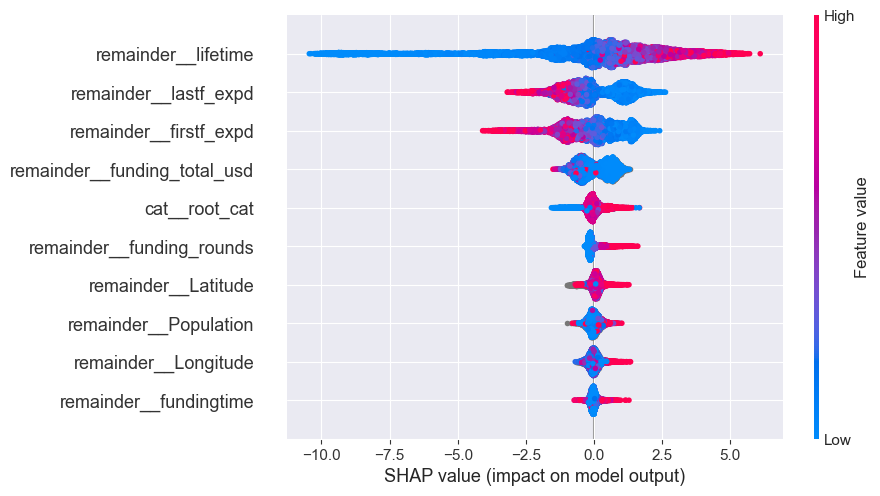

In [148]:
 # Визуализируем beeswarm-график для SHAP значений
shap.plots.beeswarm(shap_values, max_display=300)